# Part 1: Markov chain modeling
## (1) Write down a (discrete time) Markov chain model for 𝑋_t.

In [81]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

In [82]:
def demand(k,lam):
    return ((np.e**(-lam))*lam**k)/math.factorial(k)

Text(0, 0.5, 'Probability D(t)=k')

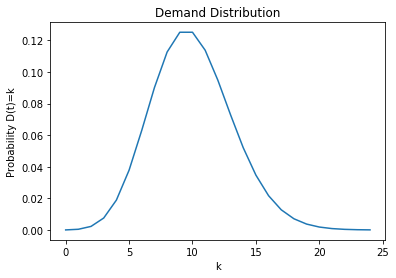

In [3]:
#Construct Transition Probability Matrix P
s = 81 #number of states
lam=10
P = np.ones((s, s))
for i in range(-30,51):
    for j in range(-30,51):
        if ((50+i-j)<0) or (j>50):
            P[i+30,j+30] = 0
        elif i >= 0:
            P[i+30,j+30] = demand(50-j,lam)
        else:
             P[i+30,j+30] = demand(50+i-j,lam)

val = []
for i in range(25):
    val.append(demand(i,lam))
plt.plot(range(25), val)
plt.title('Demand Distribution')
plt.xlabel('k')
plt.ylabel('Probability D(t)=k')

In [4]:
solver = pywraplp.Solver('DTMC', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
objective = solver.Objective()

#decision variables

#pi[i] = pi_(i-30) ex:pi[80] = pi_50
pi = {}
for i in range(s):
     pi[i] = solver.NumVar(0, 1, 'pi_%d' %(i-30))
        
#Constraints for stationary distribution

#sum of pi's = 1
solver.Add(solver.Sum([pi[i] for i in range(s)])==1)

#pi*P = pi
for j in range(s):
    solver.Add(solver.Sum([pi[i]*P[i,j] for i in range(s)]) - pi[j] == 0)

objective.SetMinimization()
for i in range(0,30):
    if i <30:
        objective.SetCoefficient(pi[i], 1)
    else:
        objective.SetCoefficient(pi[i], 0)


#Print Output
status = solver.Solve()
if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
    for i in range(s):
        print('pi %d: ' %(i-30), pi[i].solution_value())

In [5]:
#solve using Linalg
import scipy.linalg as la
lam, vec = la.eig(P, left=True, right=False)
idx = np.argmin(np.abs(lam - 1))
w = np.real(vec[:, idx])
pi = (w/w.sum())
pi

array([-2.21714765e-42, -2.55969537e-41, -4.68727173e-41, -6.57071114e-41,
       -1.88316335e-40,  1.25812755e-40,  1.15091899e-38,  9.71792565e-38,
        7.76550458e-37,  5.22983419e-36,  3.68486258e-35,  2.69667876e-34,
        1.82077419e-33,  1.24466657e-32,  8.34623321e-32,  5.49978683e-31,
        3.57808230e-30,  2.29001900e-29,  1.44246888e-28,  8.94438592e-28,
        5.45596195e-27,  3.27364589e-26,  1.93143447e-25,  1.12024168e-24,
        6.38538386e-24,  3.57580585e-23,  1.96669458e-22,  1.06201591e-21,
        5.62868245e-21,  2.92691515e-20,  1.49272674e-19,  7.46363365e-19,
        3.65718049e-18,  1.75544663e-17,  8.25059916e-17,  3.79527561e-16,
        1.70787403e-15,  7.51464571e-15,  3.23129766e-14,  1.35714502e-13,
        5.56429457e-13,  2.22571783e-12,  8.68029952e-12,  3.29851382e-11,
        1.22045011e-10,  4.39362041e-10,  1.53776714e-09,  5.22840828e-09,
        1.72537473e-08,  5.52119915e-08,  1.71157174e-07,  5.13471521e-07,
        1.48906741e-06,  

## 2) Use stationary distribution to get a) and b)
## 2) a. Long-run average number 
The long‐run average number of units in inventory = 40

In [6]:
#1. long run avg # units in inventory:
X = [] #integers of states
for i in range(-30,51):
    X.append(i)
X = np.asarray(X)
long_run = np.dot(X,pi)
long_run

40.0

## 2) b. Service Level
The fraction of days where some customers are backlogged = 3.620001542109901e-20

In [7]:
#2. Fraction of days with unsatisfied demand:
level = 0
for i in range(0,30):
    level += pi[i]
level

3.620001542109901e-20

## Part 2: Optimization via Dynamic Programming
### (1) Bellman equation:
V(s) = max_a ( Reward + gamma * Σ P(s|a,s') * V(s'))   

Reward = cost, we defined a cost(x, A) function below, while x = states, A = order numbers.   

gamma = 0.9    

P(s|a,s') = transition probability matrix for state s given previous stater and order number, we create transition probability matrix = P below for each state action pair. 

V(s') = value for last state   

Thus, the bellman equation is max_a ( cost(x,A) + 0.9 * dot(P, V(s') )

## (2) Value iteration

In [8]:
def bellman(lam,c,h,b):
#--------------------------  
    def cost(x,A):
        if x >= 0:
            val = c*A + h*x
        else:
            val = c*A - b*x
        return -val
#--------------------------        
    #Initialize
    update = 1
    i=0
    eps = 0.05
    v_list = [np.zeros(131)]
    policy_list = []
    while update == 1:
        i+= 1
        pi = np.zeros(131)
        V = np.zeros(131)
        
        for s in range(-30,101): 
            max_v = - float('inf')
            for n in range (101 - s):
                new_state = s + n 
                
                #--------------------------                 
                #transition probabability matrix
                P = np.zeros(131)
                for i in range(-30,101):
                    if i > new_state:
                        P[i + 30] = 0
                    elif i < new_state and i > - 30: 
                        P[i + 30] = demand(new_state - i ,lam)
                P[0] = 1 - np.sum(P)
                #-------------------------- 
                
                sum_y = np.dot(P,v_list[-1])    
                v = (cost(s,n) + 0.9 * sum_y)
#                 print(cost(s,n))
#                 print(sum_y)
                if v - max_v > 0 :
                    max_v = v
                    pi[s + 30] = n
            V[s + 30] = max_v
        v_list.append(V)
        policy_list.append(pi)

        
#       Stopping Condition
        update = 0
        for i in range(131):
            if abs(v_list[-1][i]-v_list[-2][i]) > eps:
                update = 1
    
    best_v = v_list [-1]
    best_policy = policy_list[-1]


    return best_v, best_policy
              

## (3) Fix c=1 and 𝜆 = 15. Choose 5 different combinations of parameters b,h (large h and small b, small h and large b and so on) and for each: 
## a. report the optimal value starting at time 0 with x=20 units in inventory  

## b. What is the optimal strategy, i.e., what is the optimal order quantity or order up to level for each state.  

The total 5 trategies are shown below, we used   
(1) h = 20 | b = 2 (large h, small b);    
(2) h = 2 | b = 20 (large b, small h);      
(3) h = 20 | b = 25 (large h, large b);         
(4) h = 5 | b = 2 (small h, small b);         
(5) h = 7 | b = 10 (moderate h, moderate b); 

The optimal value is achieved by combination 2) h = 2 | b = 20, and optimal value starting at time 0 with x=20 units in inventory = -293.7355384791253, the optimal strategy is shown below:   

[50. 49. 48. 47. 46. 45. 44. 43. 42. 41. 40. 39. 38. 37. 36. 35. 34. 33. 32. 31. 30. 29. 28. 27. 26. 25. 24. 23. 22. 21. 20. 19. 18. 17. 16. 15. 14. 13. 12. 11. 10.  9.  8.  7.  6.  5.  4.  3.  2.  1.  0.  0.  0.  0. 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 0.  0.  0.  0.  0.]

In [10]:
#(1) h = 20 | b = 2
lam = 15
c = 1
h = 20
b = 2
inventory = 20
v, policy = bellman(lam,c,h,b)
print("(1) h = 20, b = 2 \n")
print("a. Optimal value starting at time 0 with x=20 units in inventory:\n")
print(v[inventory+30])
print("\n")
print("b. Optimal strategy: \n")
print(policy)


(1) h = 20, b = 2 

a. Optimal value starting at time 0 with x=20 units in inventory:

-725.3864993665342


b. Optimal strategy: 

[40. 39. 38. 37. 36. 35. 34. 33. 32. 31. 30. 29. 28. 27. 26. 25. 24. 23.
 22. 21. 20. 19. 18. 17. 16. 15. 14. 13. 12. 11. 10.  9.  8.  7.  6.  5.
  4.  3.  2.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]


In [11]:
# converge = True
# for i in range(131):
#     if abs(v[-1][i] - v[-2][i]) > eps:
#         converge = False


In [12]:
#(2) h = 2 | b = 20
lam = 15
c = 1
h = 2
b = 20
inventory = 20
v, policy = bellman(lam,c,h,b)
print("(2) h = 2, b = 20 \n")
print("a. Optimal value starting at time 0 with x=20 units in inventory:\n")
print(v[inventory+30])
print("\n")
print("b. Optimal strategy: \n")
print(policy)

(2) h = 2, b = 20 

a. Optimal value starting at time 0 with x=20 units in inventory:

-306.6260246008571


b. Optimal strategy: 

[50. 49. 48. 47. 46. 45. 44. 43. 42. 41. 40. 39. 38. 37. 36. 35. 34. 33.
 32. 31. 30. 29. 28. 27. 26. 25. 24. 23. 22. 21. 20. 19. 18. 17. 16. 15.
 14. 13. 12. 11. 10.  9.  8.  7.  6.  5.  4.  3.  2.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]


In [13]:
#(3) h = 20 | b = 25
lam = 15
c = 1
h = 20
b = 25
inventory = 20
v, policy = bellman(lam,c,h,b)
print("h = 20 | b = 25 \n")
print("a. Optimal value starting at time 0 with x=20 units in inventory:\n")
print(v[inventory+30])
print("\n")
print("b. Optimal strategy: \n")
print(policy)

h = 20 | b = 25 

a. Optimal value starting at time 0 with x=20 units in inventory:

-1188.7337183684804


b. Optimal strategy: 

[45. 44. 43. 42. 41. 40. 39. 38. 37. 36. 35. 34. 33. 32. 31. 30. 29. 28.
 27. 26. 25. 24. 23. 22. 21. 20. 19. 18. 17. 16. 15. 14. 13. 12. 11. 10.
  9.  8.  7.  6.  5.  4.  3.  2.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]


In [14]:
#(4) h = 5 | b = 2
lam = 15
c = 1
h = 5
b = 2
inventory = 20
v, policy = bellman(lam,c,h,b)
print("(4) h = 5 | b = 2 \n")
print("a. Optimal value starting at time 0 with x=20 units in inventory:\n")
print(v[inventory+30])
print("\n")
print("b. Optimal strategy: \n")
print(policy)

(4) h = 5 | b = 2 

a. Optimal value starting at time 0 with x=20 units in inventory:

-324.654599626344


b. Optimal strategy: 

[43. 42. 41. 40. 39. 38. 37. 36. 35. 34. 33. 32. 31. 30. 29. 28. 27. 26.
 25. 24. 23. 22. 21. 20. 19. 18. 17. 16. 15. 14. 13. 12. 11. 10.  9.  8.
  7.  6.  5.  4.  3.  2.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]


In [15]:
#(5) h = 7 | b = 10
lam = 15
c = 1
h = 7
b = 10
inventory = 20
v, policy = bellman(lam,c,h,b)
print("(5) h = 7 | b = 10 \n")
print("a. Optimal value starting at time 0 with x=20 units in inventory:\n")
print(v[inventory+30])
print("\n")
print("b. Optimal strategy: \n")
print(policy)

(5) h = 7 | b = 10 

a. Optimal value starting at time 0 with x=20 units in inventory:

-514.5502181558186


b. Optimal strategy: 

[46. 45. 44. 43. 42. 41. 40. 39. 38. 37. 36. 35. 34. 33. 32. 31. 30. 29.
 28. 27. 26. 25. 24. 23. 22. 21. 20. 19. 18. 17. 16. 15. 14. 13. 12. 11.
 10.  9.  8.  7.  6.  5.  4.  3.  2.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]


# Problem 3

# 2) Q - learning algorithm

In [78]:
def Qlearn(lamda,c,h,b):
#--------------------------------------------
    def cost(x,A):
        if x >= 0:
            val = c*A + h*x
        else:
            val = c*A - b*x
        return -val
#----------------------------------------------
    #initialize
    Q = np.zeros([131,131])
    epsilon = 0.2
    #Start with 20 in inventory
    for j in range(500):
        for i in range(-30,101):
            t = 0
            states = [i]
            actions = [0]
            update = 1
            while update <= 10000:
                current_state = states[t]
                alpha = 1/(t+1)
                if np.random.uniform(0, 1) < epsilon:
                    action = np.random.randint(0,101 - current_state) # Explore action space with prob=epsilon
                else:
                    action = np.argmax(Q[current_state][:101 - current_state]) # use learned values
                state_update = current_state + action - np.random.poisson(lamda)
                if state_update < -30:
                    next_state = -30
                else:
                    next_state = state_update
                Q[current_state+30,action] += alpha * (cost(current_state,action) + 0.9*np.max(Q[next_state+30,:101 - next_state])
                                                     - Q[current_state+30,action])
                states.append(next_state)
                t += 1
                update += 1
    #         print(t)
        #stopping condition
    #         if t > 120:
    return Q

In [79]:
#(2) h = 2 | b = 20
lam = 15
c = 1
h = 2
b = 20
inventory = 20
Q = Qlearn(lam,c,h,b)
Q

array([[ -632.08244102,  -607.12808414,  -630.12559075, ...,
         -247.34745787,  -387.90216304, -1159.69563141],
       [ -593.06368601,   -22.55476819,   -87.46980539, ...,
        -1141.07998414, -1139.85088751,     0.        ],
       [ -561.43779731,  -592.50169466,  -567.6230723 , ...,
        -1119.17039844,     0.        ,     0.        ],
       ...,
       [ -594.25589951,  -596.26590069,  -655.11498851, ...,
            0.        ,     0.        ,     0.        ],
       [ -536.95571044,  -644.49911582,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [ -619.40372034,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])

## 3) provide visuals that capture the convergence of the Q‐learning algorithm

We used second group of combination from part 2: (λ, c, h, b) = (15, 1, 2, 20), the result and graph is shown below. 


In [59]:
#(2) h = 2 | b = 20
lam = 15
c = 1
h = 2
b = 20
inventory = 20
Q = Qlearn(lam,c,h,b)
Q

array([[-6.00356525e+02, -1.50945105e+01, -1.91650230e+01, ...,
        -2.94506767e+01, -3.84506138e+02, -3.95188375e+01],
       [-5.80318270e+02, -1.92821374e+00, -4.04534335e-01, ...,
        -1.00639471e+00, -5.28324397e-01,  0.00000000e+00],
       [-1.92843311e+01, -5.67891253e+02, -2.84111978e+00, ...,
        -1.04474080e+03,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-5.38403081e+02, -5.48606425e+02, -5.80784242e+02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.93727031e+02, -5.94584124e+02,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.94513752e+02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

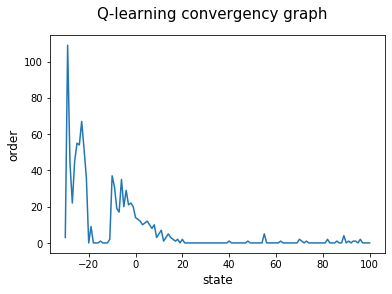

In [80]:
# order number = n
# state = s
n_list = []
for i in range (131):
    n = np.argmax(Q[i][:131 - i])
    n_list.append(n) 
s = list(range(-30,101))
fig = plt.figure()
plt.plot(s, n_list)
fig.suptitle('Q-learning convergency graph', fontsize=15)
plt.xlabel('state', fontsize=12)
plt.ylabel('order', fontsize=12)
plt.show()

In [77]:
print("a. Optimal value starting at time 0 with x=20 units in inventory:\n")
print(np.max(Q[50][:101 - 50 + 30]))
print("\n")
print("b. Optimal strategy: \n")
print(np.array(n_list))

a. Optimal value starting at time 0 with x=20 units in inventory:

-41.703915156977104


b. Optimal strategy: 

[37  2 36 44 18 16  1 21  7 13 55  6 38 30 34 47 36 35 38 26 22 45 30 31
 20 23 24 15 13 12 15  7  5  9  0  6 11  5  9  6  3  1  1  0  0  0  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  1  1  1  0  1  0  0  2  2  0  0  1  0  3  1  1  0  0  0  0  2  2  1
  1  0  3  2  2  1  0  2  0  0  2  2  3  1  0  1  2  0  4  3  7 13 11  8
  7  3  7  7  6  4  3  1  0  0  0]
